In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [4]:
# Dataset paths
TRAIN_DIR = "Jute_Pest_Dataset_Split/train"
VALID_DIR = "Jute_Pest_Dataset_Split/val"
TEST_DIR = "Jute_Pest_Dataset_Split/test"

# Dataset parameters
IMG_HEIGHT = 224  # Standard size for most pre-trained models
IMG_WIDTH = 224
BATCH_SIZE = 32
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [5]:
def create_data_generators():
    """
    Create data generators for train, validation, and test sets.
    Uses ImageDataGenerator for data augmentation and preprocessing.
    """
    # Training data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Validation and test data (only rescaling, no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create generators
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    valid_generator = val_test_datagen.flow_from_directory(
        VALID_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Get number of classes
    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())
    
    print(f"\nDataset Information:")
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {valid_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    
    return train_generator, valid_generator, test_generator, num_classes, class_names

train_gen, valid_gen, test_gen, num_classes, class_names = create_data_generators()

Found 5005 images belonging to 17 classes.
Found 1073 images belonging to 17 classes.
Found 1102 images belonging to 17 classes.

Dataset Information:
Number of classes: 17
Class names: ['Beet Armyworm', 'Black Hairy', 'Cutworm', 'Field Cricket', 'Jute Aphid', 'Jute Hairy', 'Jute Red Mite', 'Jute Semilooper', 'Jute Stem Girdler', 'Jute Stem Weevil', 'Leaf Beetle', 'Mealybug', 'Pod Borer', 'Scopula Emissaria', 'Termite', 'Termite odontotermes (Rambur)', 'Yellow Mite']
Training samples: 5005
Validation samples: 1073
Test samples: 1102


In [6]:

def create_resnet_transfer_model(input_shape, num_classes, trainable_layers=0):
    """
    Create a transfer learning model using pre-trained ResNet50.
    """
    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model initially
    base_model.trainable = False
    
    # Optionally unfreeze some layers for fine-tuning
    if trainable_layers > 0:
        base_model.trainable = True
        # Freeze all layers except the last trainable_layers
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
    
    # Create new model with custom classification head
    inputs = keras.Input(shape=input_shape)
    
    # Pre-process inputs for ResNet50
    x = keras.applications.resnet50.preprocess_input(inputs)
    
    # Pass through base model
    x = base_model(x, training=False)
    
    # Add custom classification head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    return model

# 1. ResNet50 Transfer Learning
print("\nCreating ResNet50 model...")
resnet_model = create_resnet_transfer_model(INPUT_SHAPE, num_classes, 
                                            trainable_layers=10)
print(f"\nResNet50 Total Parameters: {resnet_model.count_params():,}")
trainable_params = sum([tf.keras.backend.count_params(w) 
                        for w in resnet_model.trainable_weights])
print(f"ResNet50 Trainable Parameters: {trainable_params:,}")


Creating ResNet50 model...



ResNet50 Total Parameters: 24,116,625
ResNet50 Trainable Parameters: 4,994,577


In [ ]:
# Train all models

def train_model(model, train_gen, val_gen, model_name, epochs=20, learning_rate=0.01):
    """
    Train a model and return training history.
    """
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        f'{model_name.replace(" ", "_").lower()}_best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Train model
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}\n")
    
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1
    )
    
    return history


histories = []
models = [resnet_model]
model_names = ['ResNet50']

for model, name in zip(models, model_names):
    history = train_model(
        model, train_gen, valid_gen,
        model_name=name,
        epochs=20,
        learning_rate=0.001
    )
    histories.append(history)




Training ResNet50

Epoch 1/20


157/157 [==============================] - ETA: 0s - loss: 2.8312 - accuracy: 0.0885
Epoch 1: val_accuracy improved from -inf to 0.10624, saving model to resnet50_best_model.h5


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 281s 2s/step - loss: 2.8312 - accuracy: 0.0885 - val_loss: 2.7867 - val_accuracy: 0.1062 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 2.7789 - accuracy: 0.1101
Epoch 2: val_accuracy improved from 0.10624 to 0.11556, saving model to resnet50_best_model.h5
157/157 [==============================] - 263s 2s/step - loss: 2.7789 - accuracy: 0.1101 - val_loss: 2.7600 - val_accuracy: 0.1156 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 2.7277 - accuracy: 0.1083
Epoch 3: val_accuracy improved from 0.11556 to 0.12954, saving model to resnet50_best_model.h5
157/157 [==============================] - 260s 2s/step - loss: 2.7277 - accuracy: 0.1083 - val_loss: 2.6860 - val_accuracy: 0.1295 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 2.6999 - accuracy: 0.1185
Epoch 4: val_accuracy improved from 0.12954 to 0.14632, saving model to resnet50_best_m

In [17]:
# Evaluate all models

def evaluate_model(model, test_gen, model_name, class_names):
    
    print(f"Evaluating {model_name}")
    
    # Reset test generator
    test_gen.reset()
    
    # Predictions
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # True labels
    y_true = test_gen.classes
    
    # Test accuracy
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'predictions': y_pred,
        'true_labels': y_true,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_pred, 
                                                      target_names=class_names,
                                                      output_dict=True)
    }

results = []
for model, name in zip(models, model_names):
    result = evaluate_model(model, test_gen, name, class_names)
    results.append(result)

Evaluating ResNet50
35/35 [==============================] - 53s 1s/step
Test Loss: 2.4096
Test Accuracy: 0.2359

Classification Report:
                               precision    recall  f1-score   support

                Beet Armyworm       0.00      0.00      0.00        40
                  Black Hairy       0.27      0.05      0.09        55
                      Cutworm       0.09      0.18      0.12        67
                Field Cricket       0.29      0.37      0.33        65
                   Jute Aphid       0.12      0.07      0.09        88
                   Jute Hairy       0.29      0.06      0.10        67
                Jute Red Mite       0.42      0.39      0.41        80
              Jute Semilooper       0.12      0.05      0.07        61
            Jute Stem Girdler       0.36      0.79      0.50        48
             Jute Stem Weevil       0.28      0.21      0.24       117
                  Leaf Beetle       0.00      0.00      0.00        52
          

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


GENERATING COMPARISON PLOTS


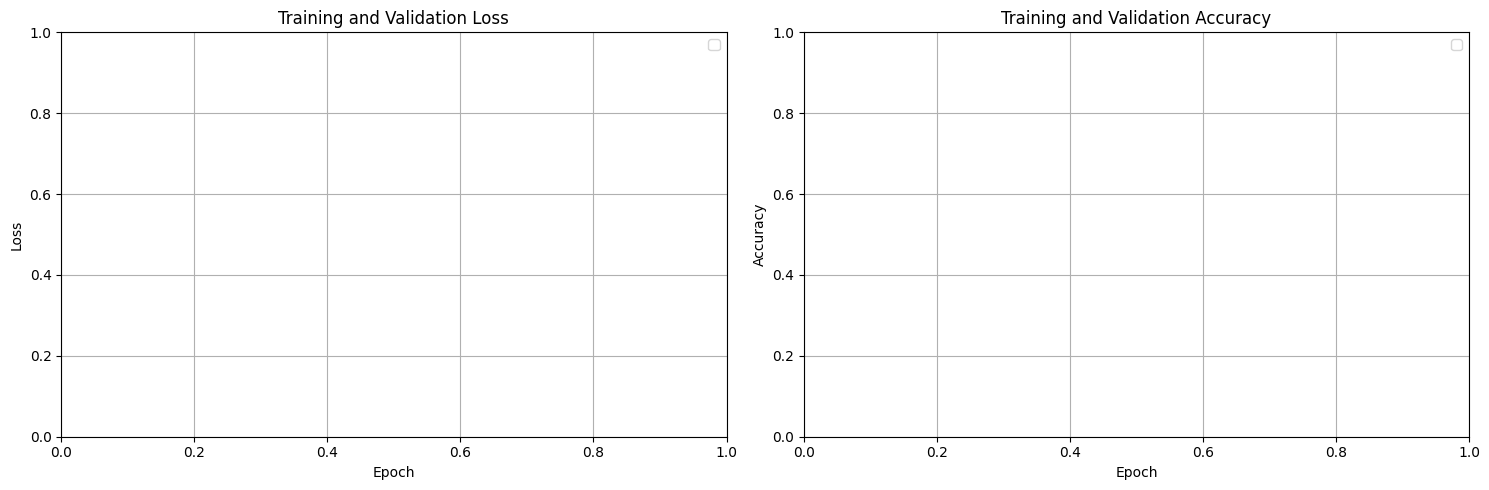

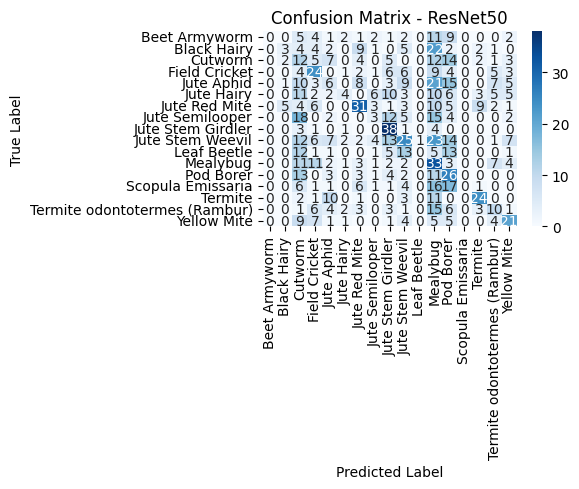

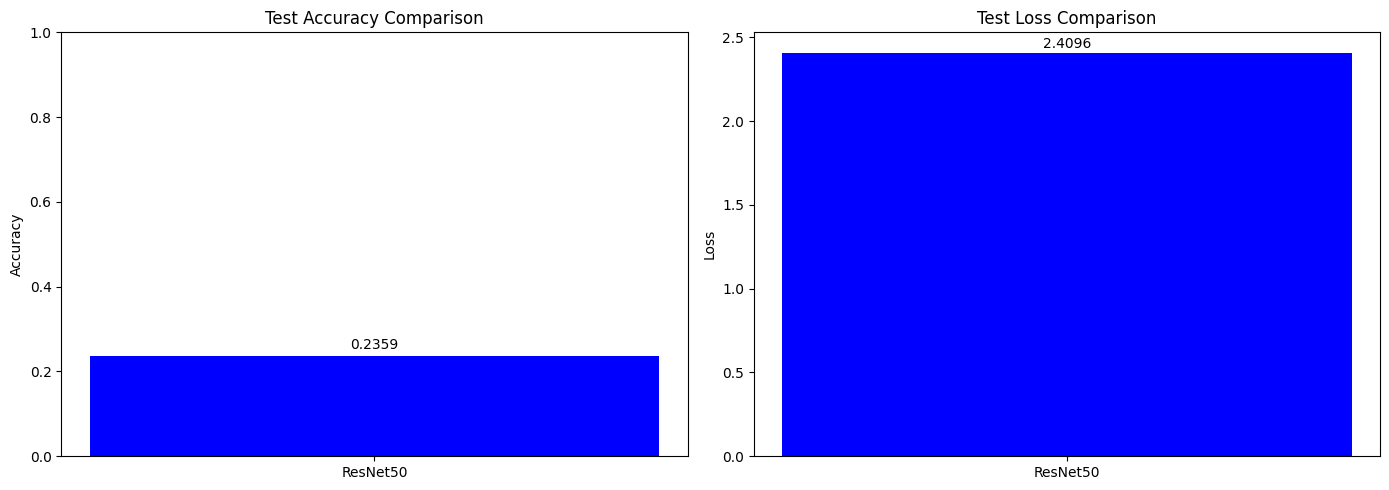

FINAL PERFORMANCE SUMMARY

ResNet50:
  Test Accuracy: 0.2359
  Test Loss: 2.4096

  Per-Class Metrics:
    Beet Armyworm:
      Precision: 0.0000
      Recall: 0.0000
      F1-Score: 0.0000
    Black Hairy:
      Precision: 0.2727
      Recall: 0.0545
      F1-Score: 0.0909
    Cutworm:
      Precision: 0.0876
      Recall: 0.1791
      F1-Score: 0.1176
    Field Cricket:
      Precision: 0.2927
      Recall: 0.3692
      F1-Score: 0.3265
    Jute Aphid:
      Precision: 0.1224
      Recall: 0.0682
      F1-Score: 0.0876
    Jute Hairy:
      Precision: 0.2857
      Recall: 0.0597
      F1-Score: 0.0988
    Jute Red Mite:
      Precision: 0.4247
      Recall: 0.3875
      F1-Score: 0.4052
    Jute Semilooper:
      Precision: 0.1250
      Recall: 0.0492
      F1-Score: 0.0706
    Jute Stem Girdler:
      Precision: 0.3619
      Recall: 0.7917
      F1-Score: 0.4967
    Jute Stem Weevil:
      Precision: 0.2841
      Recall: 0.2137
      F1-Score: 0.2439
    Leaf Beetle:
      Precision

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved: resnet50_final_model.h5

COMPARISON COMPLETE!

Generated files:
  - model_comparison_training.png
  - confusion_matrices_comparison.png
  - performance_comparison.png
  - resnet50_best_model.h5


In [18]:
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    for history, name in zip(histories, model_names):
        axes[0].plot(history.history['loss'], label=f'{name} - Train')
        axes[0].plot(history.history['val_loss'], label=f'{name} - Val', linestyle='--')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    for history, name in zip(histories, model_names):
        axes[1].plot(history.history['accuracy'], label=f'{name} - Train')
        axes[1].plot(history.history['val_accuracy'], label=f'{name} - Val', linestyle='--')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('model_comparison_training.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrices(results, model_names, class_names=None):
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (result, name) in enumerate(zip(results, model_names)):
        sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', 
                   cmap='Blues', ax=axes[idx],
                   xticklabels=class_names if class_names else 'auto',
                   yticklabels=class_names if class_names else 'auto')
        axes[idx].set_title(f'Confusion Matrix - {name}')
        axes[idx].set_ylabel('True Label')
        axes[idx].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_performance_comparison(results, model_names):
    """
    Create bar plots comparing model performance metrics.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Extract metrics
    accuracies = [r['test_accuracy'] for r in results]
    losses = [r['test_loss'] for r in results]
    
    # Plot accuracy comparison
    axes[0].bar(model_names, accuracies, color=['blue', 'green', 'orange'])
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Test Accuracy Comparison')
    axes[0].set_ylim([0, 1])
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    # Plot loss comparison
    axes[1].bar(model_names, losses, color=['blue', 'green', 'orange'])
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Test Loss Comparison')
    for i, v in enumerate(losses):
        axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

  
    
# Visualize comparisons
print("GENERATING COMPARISON PLOTS")
print("="*60)

plot_training_history(histories, model_names)
plot_confusion_matrices(results, model_names, class_names)
plot_performance_comparison(results, model_names)

# Print summary comparison
print("FINAL PERFORMANCE SUMMARY")
print("="*60)

for name, result in zip(model_names, results):
    print(f"\n{name}:")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"  Test Loss: {result['test_loss']:.4f}")
    
    # Get per-class metrics
    report = result['classification_report']
    print(f"\n  Per-Class Metrics:")
    for class_name in class_names:
        if class_name in report:
            print(f"    {class_name}:")
            print(f"      Precision: {report[class_name]['precision']:.4f}")
            print(f"      Recall: {report[class_name]['recall']:.4f}")
            print(f"      F1-Score: {report[class_name]['f1-score']:.4f}")

# Save final models
print("SAVING MODELS")
print("="*60)

for model, name in zip(models, model_names):
    filename = f'{name.replace(" ", "_").lower()}_final_model.h5'
    model.save(filename)
    print(f"Saved: {filename}")

print("\n" + "="*60)
print("COMPARISON COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  - model_comparison_training.png")
print("  - confusion_matrices_comparison.png")
print("  - performance_comparison.png")
print("  - resnet50_best_model.h5")



